In [1]:
import sys
sys.path.append('/home/campbell/yulee/DAMM/new/code/pro')

from funcs6 import *
import joblib

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
plt.rcParams['figure.figsize'] = [20, 10]

In [2]:
cohort = 'meta'
ss = 10

In [3]:
tr_exp = sc.read_h5ad('/home/campbell/yulee/DAMM/new/data/{}/{}k/tr_exp.h5ad'.format(cohort, ss))
te_exp = sc.read_h5ad('/home/campbell/yulee/DAMM/new/data/{}/{}k/te_exp.h5ad'.format(cohort, ss))
pretty_printing = np.hstack([tr_exp.var_names, 'size'])

In [4]:
#nc = len(analysisProteins)
batchSize = 128
learnRate = 1e-3
nm = 'student'
rr = 1
rv = 10 #1000 
r = 0

In [5]:
## compute training and test set
#trY, trS = prepData(tr_exp, 1, analysisProteins) ## inc cell sizes
#teY, teS = prepData(te_exp, 1, analysisProteins) ## inc cell sizes

trY, trS = prepData(tr_exp, 1) ## inc cell sizes
teY, teS = prepData(te_exp, 1) ## inc cell sizes

trFY, trFS, trFL = simulate_data(trY, trS, 1) ## relax rule
teFY, teFS, teFL = simulate_data(teY, teS, 1) ## relax rule

trMat = np.hstack((trY, trS.reshape(-1,1)))
teMat = np.hstack((teY, teS.reshape(-1,1)))
trFMat = np.hstack((trFY, trFS.reshape(-1,1)))
teFMat = np.hstack((teFY, teFS.reshape(-1,1)))
df = ConcatDataset(trY, trS, trFY, trFS, trFL)

In [6]:
trMat.dtype

dtype('float64')

# PhenoGraph

In [7]:
#import phenograph
import scanpy.external as sce
pheno_labels, _, _ = sce.tl.phenograph(trMat)
tr_exp.obs['pheno_label'] = pheno_labels.astype(str)

## set number of clusters
nc = len(np.unique(pheno_labels))
pheno_centers = np.zeros((nc, trMat.shape[1]))
for k in range(nc):
    pheno_centers[k,:] = trMat[pheno_labels==k].mean(0)

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 6.5889892578125 seconds
Jaccard graph constructed in 1.3659768104553223 seconds
Wrote graph to binary file in 0.32219862937927246 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.820595
Louvain completed 21 runs in 5.713615417480469 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 14.27097225189209 seconds


In [8]:
tr_exp.obs['pheno_label'].value_counts()

0     999
1     926
2     848
3     796
4     723
5     640
6     546
7     541
8     516
9     459
10    452
11    431
12    405
13    371
14    298
15    297
16    224
17    221
18    182
19    125
Name: pheno_label, dtype: int64

In [9]:
nc

20

# FlowSOM

In [10]:
from flowsom import flowsom as flowsom
from sklearn.cluster import AgglomerativeClustering

oPath = '/home/campbell/yulee/DAMM/new/res/{}/{}k/ex1/'.format(cohort, ss)
fs_fn = oPath + 'fsom1t_nc{}_{}_rv{}_rr{}_{}.csv'.format(nc, nm, rv, rr, r)
pd.DataFrame(np.array(trMat), columns = pretty_printing).to_csv(fs_fn)
fsom = flowsom(fs_fn, if_fcs=False, if_drop=True, drop_col=['Unnamed: 0'])

#fn = oPath + 'fsom1.csv'
#fsom = flowsom(fn, if_fcs=False, if_drop=True, drop_col=['Unnamed: 0'])

fsom.som_mapping(50, # x_n: e.g. 100, the dimension of expected map
       50, # y_n: e.g. 100, the dimension of expected map
       fsom.df.shape[1],
       1, # sigma: e.g 1, the standard deviation of initialized weights
       0.5, # lr: e.g 0.5, learning rate
       1000, # batch_size: 1000, iteration times
       tf_str=None, # string, e.g. hlog', None, etc - the transform algorithm
       if_fcs=False # bool, whethe the imput file is fcs file. If not, it should be a csv file
       # seed = 10, for reproducing
      )

start = nc; fsom_nc = 0
while fsom_nc < nc:
    print(nc, start, fsom_nc)
    fsom.meta_clustering(AgglomerativeClustering, min_n=start, max_n=start, verbose=True, iter_n=10) # train the meta clustering for cluster in range(40,45)  

    fsom.labeling()
    #fsom.bestk # the best number of clusters within the range of (min_n, max_n)
    fsom_class = np.unique(fsom.df['category'])
    fsom_nc = len(fsom_class)
    start += 1
    
fsom_labels = np.array(fsom.df['category'])
fsom_sorted_by_count = pd.Series(fsom_labels).value_counts().index

tr_exp.obs['fsom_label'] = 0
for i, val in enumerate(fsom_sorted_by_count):
    idx = fsom_labels == val
    tr_exp.obs['fsom_label'].iloc[idx] = str(i)
    #print(len(tr_exp.obs['fsom_label'].iloc[idx]))
tr_exp.obs['fsom_label'] = tr_exp.obs['fsom_label'].astype(str)

#fsom.meta_clustering(AgglomerativeClustering, min_n=start, max_n=start, verbose=True, iter_n=5)
fsom_centers = np.zeros((max(fsom_class)+1, fsom.df.shape[1]))
for row in range(max(fsom_class)+1):
    fsom_centers[row,:] = fsom.df[fsom_labels==row].mean(0)

fsom_centers = fsom_centers[fsom_sorted_by_count]
fs_centers = fsom_centers[:,:-1]
#pd.DataFrame(fs_centers, columns = fsom.df.columns[:-1])
#pd.DataFrame(out_center, columns = fsom.df.columns[:-1]).to_csv(oName)
#fsom.df['category'].to_csv(oPath + 'fsom{}_label_nc{}.csv'.format(cs, fsom_nc))

Training...
 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 15.251908380073527

...ready!
20 20 0
0 samples done...
20 21 19
0 samples done...


/tmp/ipykernel_23804/121609084.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tr_exp.obs['fsom_label'].iloc[idx] = str(i)


In [11]:
tr_exp.obs['fsom_label'].value_counts()

0     1548
1     1071
2      979
3      813
4      787
5      747
6      666
7      643
8      468
9      424
10     349
11     312
12     251
13     225
14     173
15     167
16     162
17     139
18      68
19       8
Name: fsom_label, dtype: int64

# Random Forest

In [12]:
## run random forest
rf = RandomForestClassifier()
rf.fit(trFMat, trFL)

## save classifiers
#joblib.dump(rf, orf_classifier)

## compute random forest performance of simulated data (confusion matrix)
rf_p_fake_singlet = rf.predict_proba(teFMat)[:,1]
rtn, rfp, rfn, rtp, racc, rf1, rsens, rspec = evalM(rf_p_fake_singlet, teFL)

In [13]:
rf1

0.8025154681002131

# Kmeans Initalization

In [14]:
## damm initialization
Theta0, okms_labels, okms_centers = kmeans_init1(trMat, 1, nc) ## inc cell sizes

## save kmeans results as damm initialization
#torch.save(Theta, output_theta0)

## save kmeans labels (in anndata object)
okms_sorted_by_count = pd.Series(okms_labels).value_counts().index

tr_exp.obs['kms_label'] = 0
for i, val in enumerate(okms_sorted_by_count):
    idx = okms_labels == val
    tr_exp.obs['kms_label'].iloc[idx] = str(i)
    #print(len(tr_exp.obs['fsom_label'].iloc[idx]))
tr_exp.obs['kms_label'] = tr_exp.obs['kms_label'].astype(str)

## save kmeans centers
okms_centers = okms_centers[okms_sorted_by_count]
#pd.DataFrame(okms_centers, columns = pretty_printing).to_csv(ookms_centers)

/tmp/ipykernel_23804/4079753086.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tr_exp.obs['kms_label'].iloc[idx] = str(i)


In [15]:
tr_exp.obs['kms_label'].value_counts()

0     984
1     948
2     860
3     752
4     699
5     665
6     658
7     580
8     544
9     543
10    446
11    411
12    372
13    337
14    282
15    241
16    194
17    182
18    170
19    132
Name: kms_label, dtype: int64

## RF on Kmeans

In [16]:
#singlet_indices = np.where(rf.predict_proba(okms_centers)[:,0] <= 0.5)[0]
#Theta1 = {k: v.detach()[singlet_indices].requires_grad_(True) for (k,v) in Theta0.items()}
#Theta1['is_tau'] = Theta1['is_tau'].detach()[:,np.r_[singlet_indices]].requires_grad_(True)

# DAMM

In [17]:
loss, Theta1 = trainWFD(df, rr, Theta0, batchSize, nm, learnRate, rv)

/home/campbell/yulee/DAMM/new/code/pro/funcs6.py:237: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  ccmax = torch.combinations(psi).max(1).values


## Loss Curve

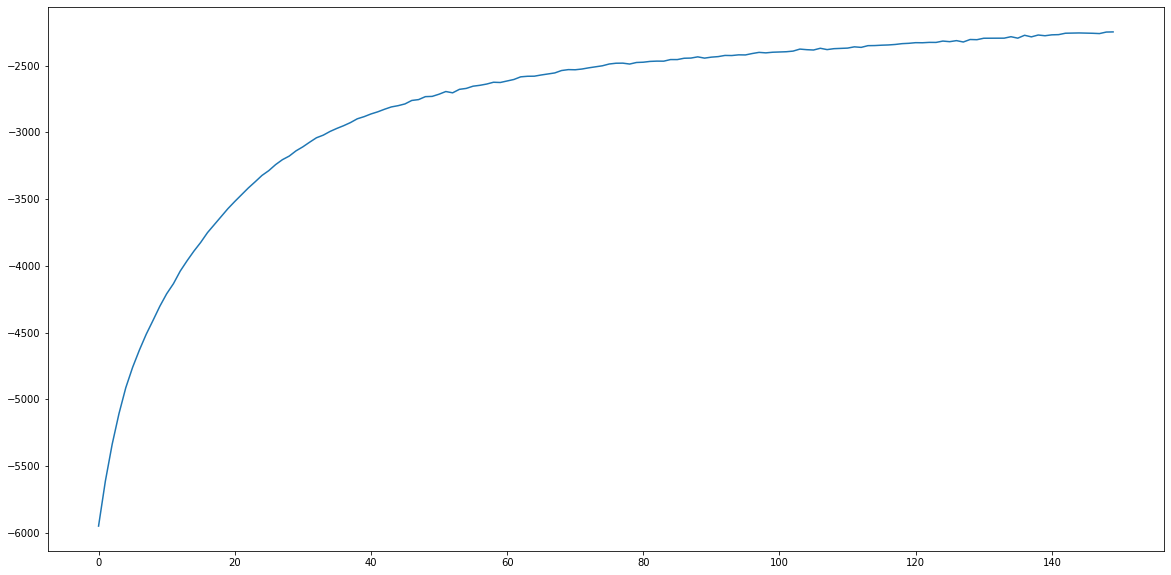

In [18]:
## total loss
plt.plot(np.array(loss)[:,0])

## Label

In [19]:
## output model parameters
#torch.save([loss, Theta], output_theta1)

## damm's doublet performance
with torch.no_grad():
    
    pred_loader = torch.utils.data.DataLoader(ConcatDataset(teFY, teFS), batch_size = 5000, shuffle = False)
    
    damm_p_fake_singlets = []
    for i, bat in enumerate(pred_loader):
        _, _, _ , damm_p_fake_singlet = compute_posteriors_nll_p_singlet(bat[0], bat[1], Theta1, nm, rr)
        damm_p_fake_singlets.append(damm_p_fake_singlet)
        
    ## compute damm performance of simulated data (confusion matrix)
    dtn, dfp, dfn, dtp, dacc, df1, dsens, dspec = evalM(torch.hstack(damm_p_fake_singlets), teFL)
    
    iter_out = [nc, nm, rv, rr, r, 
        rtn, rfp, rfn, rtp, racc, rf1, rsens, rspec,
        dtn, dfp, dfn, dtp, dacc, df1, dsens, dspec]

    ## output doublet performances
    #pd.Series(iter_out).to_csv(odoublet_performance)
    
    ## DAMM label
    damm_pred_singlet_label, damm_pred_singlet_cluster_assig_label, _ = get_assign_labels1(trY, trS, rr, Theta1, nm)    
    damm_sorted_by_count = pd.Series(damm_pred_singlet_cluster_assig_label).value_counts().index
    
    if len(damm_sorted_by_count) != nc:
        damm_sorted_by_count = np.hstack((damm_sorted_by_count, np.setdiff1d(range(nc), damm_sorted_by_count)))
        
    ## save damm labels
    damm_label = np.zeros(trY.shape[0]) + 50
    damm_label[damm_pred_singlet_label == 0] = damm_pred_singlet_cluster_assig_label
    
    #tr_exp.obs['damm_label'] = 50 #len(np.unique(damm_pred_singlet_cluster_assig_label))
    #tr_exp.obs.iloc[np.where(damm_pred_singlet_label == 0)[0],-1] = damm_pred_singlet_cluster_assig_label
    
    ## sorted labels by clusters
    tr_exp.obs['damm_label'] = 50
    for i, val in enumerate(damm_sorted_by_count):
        idx = damm_label == val
        tr_exp.obs['damm_label'].iloc[idx] = str(i)
    tr_exp.obs['damm_label'] = tr_exp.obs['damm_label'].astype(str)

    ## save damm centers
    damm_centers = np.array(torch.hstack([Theta1['log_mu'], Theta1['log_psi'].reshape(-1,1)]).exp())
    damm_centers = damm_centers[damm_sorted_by_count]
    #pd.DataFrame(damm_centers, columns = pretty_printing).to_csv(odamm_centers)

    ## output phenograph/kmeans/damm labels
    #tr_exp.obs.iloc[:,5:].to_csv(olabels)

/tmp/ipykernel_23804/2720189160.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tr_exp.obs['damm_label'].iloc[idx] = str(i)


In [20]:
tr_exp.obs['damm_label'].value_counts()

0     2253
50    1744
1     1259
2     1121
3     1055
4      788
5      615
6      451
7      309
8      232
9       58
10      32
11      23
12      19
13      13
14      10
15       7
16       6
17       4
18       1
Name: damm_label, dtype: int64

## Doublet Probability

In [21]:
with torch.no_grad():
    _, _, _, p_singlet = compute_posteriors_nll_p_singlet(trY, trS, Theta1, nm, rr)
tr_exp.obs['prob_doublet'] = 1 - p_singlet

/home/campbell/yulee/.local/share/virtualenvs/yulee-9RaDnU2W/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'pheno_label' as categorical
/home/campbell/yulee/.local/share/virtualenvs/yulee-9RaDnU2W/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'fsom_label' as categorical
/home/campbell/yulee/.local/share/virtualenvs/yulee-9RaDnU2W/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` pa

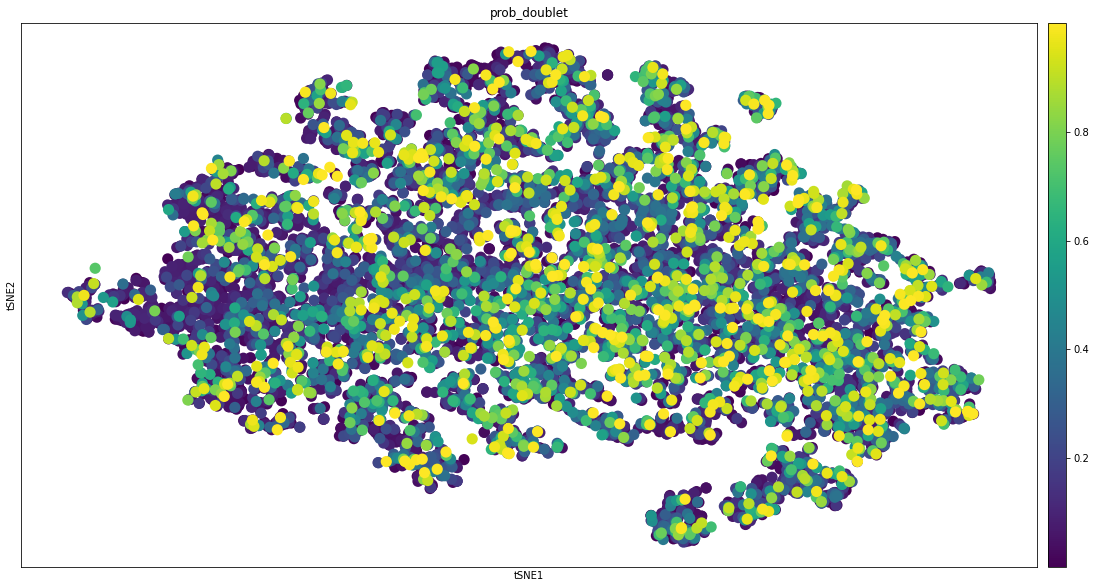

In [22]:
sc.tl.tsne(tr_exp)
sc.pl.tsne(tr_exp, color="prob_doublet", size=500)

In [23]:
## compute neighbors for tsne
#sc.pp.scale(tr_exp, max_value=3)
#sc.tl.pca(tr_exp)
#sc.pp.neighbors(tr_exp, use_rep="X_pca")
#sc.tl.tsne(tr_exp)
#sc.pl.tsne(tr_exp, color="prob_doublet", size=500)

In [24]:
sum(p_singlet.detach() > 0.5)

tensor(8256)

In [25]:
pd.DataFrame(pheno_centers, columns = pretty_printing)

,totHH3,H3K27me3,CK5,Fibronectin,CK19,CK8_18,Twist,CD68,CK14,SMA,...,pS6,Sox9,CD31,mTOR,CK7,panCK,cPARP-cCasp3,DNA1,DNA2,size
0,5.011266,1.094880,0.564908,4.596913,0.911363,3.655648,0.327960,0.246421,0.121913,0.531218,...,0.389637,0.129127,0.674624,0.339698,1.330579,3.933896,1.670452,20.022336,35.756147,50.391391
1,5.604001,1.298502,0.615307,6.125277,1.003394,3.723559,0.370551,0.282821,0.124248,0.738366,...,0.441246,0.133295,0.745585,0.367361,1.523450,4.102901,1.844460,24.275643,43.696058,110.361771
2,3.548131,0.912927,0.399895,7.757309,0.448218,1.151458,0.212950,0.322399,0.092452,0.883697,...,0.344987,0.081737,0.543101,0.254134,0.613852,1.489682,1.314619,16.485191,28.955488,23.106132
3,5.706440,1.076344,0.576589,5.149067,0.744276,2.299274,0.330700,0.313655,0.136395,0.774836,...,0.413697,0.115742,0.701163,0.344939,1.123073,2.689764,1.670521,40.135132,72.620961,81.776382
4,5.098467,1.094188,0.581725,5.784685,0.913695,2.886735,0.306156,0.268330,0.094370,0.600177,...,0.384336,0.110747,0.642603,0.321291,1.534925,3.179558,1.560878,27.456812,49.616262,148.941909
5,4.605711,0.945629,0.525678,5.246030,0.662872,1.951350,0.270521,0.294990,0.121607,0.748708,...,0.414834,0.104967,0.617126,0.306569,0.999525,2.415200,1.548255,20.811226,37.173551,80.231250
6,4.920577,1.011580,0.552520,4.244070,1.020108,2.591479,0.294416,0.242922,0.107090,0.602391,...,0.351958,0.116864,0.619631,0.323916,1.973338,3.386379,1.569910,27.851882,50.213549,68.406593
7,4.620205,0.857348,0.474264,4.687102,0.586570,1.553891,0.263371,0.322650,0.105106,0.681891,...,0.355937,0.094742,0.569508,0.282789,0.778277,1.855908,1.385664,29.233317,52.798854,91.611830
8,5.163701,0.917789,0.541689,3.870509,0.696434,1.547997,0.289149,0.279105,0.130318,0.727310,...,0.397795,0.118905,0.602672,0.295997,1.453286,2.085822,1.560508,30.351518,54.528004,22.129845
9,5.100465,0.992805,0.499844,4.166008,0.931252,2.731600,0.302919,0.234778,0.107452,0.481224,...,0.342017,0.113111,0.615736,0.340645,1.578718,3.162012,1.542819,33.154845,60.018091,118.605664


In [26]:
pd.DataFrame(fs_centers, columns = fsom.df.columns[:-1])

,totHH3,H3K27me3,CK5,Fibronectin,CK19,CK8_18,Twist,CD68,CK14,SMA,...,pS6,Sox9,CD31,mTOR,CK7,panCK,cPARP-cCasp3,DNA1,DNA2,size
0,5.179100,0.993481,0.531965,5.132861,0.667604,1.970036,0.311518,0.366375,0.131840,0.675455,...,0.415225,0.120003,0.670320,0.325123,1.003897,2.384177,1.626414,24.178362,43.436407,45.817183
1,5.021375,1.057153,0.569527,5.310592,0.883529,2.724639,0.304124,0.265624,0.107664,0.647898,...,0.363061,0.110186,0.636177,0.324288,1.423579,3.002313,1.550741,30.351978,54.914482,132.277311
2,4.397477,0.994623,0.466616,6.561663,0.551512,1.757129,0.262588,0.328270,0.111298,0.890568,...,0.395881,0.104962,0.601134,0.288358,0.792868,2.022397,1.511623,21.386921,37.963866,20.598570
3,5.187071,1.102598,0.544745,4.941485,0.820601,2.986840,0.325613,0.246746,0.114223,0.636117,...,0.406477,0.123531,0.661490,0.339055,1.305320,3.349195,1.677378,22.977006,41.291925,97.826568
4,5.159343,1.027216,0.549953,5.523585,0.694725,2.005276,0.302620,0.348994,0.110181,0.716006,...,0.385088,0.106514,0.666168,0.320744,1.094808,2.468623,1.576351,33.389276,60.407945,98.209657
5,4.537077,1.195333,0.597986,6.696462,1.034873,3.601618,0.318739,0.266771,0.119900,0.717001,...,0.392917,0.116215,0.661474,0.333833,1.719672,3.821132,1.640900,20.197367,36.025727,66.508701
6,5.654039,0.953355,0.525136,3.751500,0.759567,2.320320,0.296206,0.236694,0.112424,0.629671,...,0.370649,0.116416,0.605194,0.329928,1.116566,2.492846,1.564805,40.097286,72.557811,50.857357
7,5.162995,1.069690,0.471012,7.445047,0.622477,1.474722,0.277973,0.353745,0.114684,0.925499,...,0.422982,0.106782,0.643761,0.304192,0.800401,2.058754,1.582412,27.077771,48.766676,75.118196
8,5.722866,1.083102,0.601212,4.960673,0.815078,2.254270,0.328839,0.326906,0.140907,0.745051,...,0.405215,0.116366,0.697033,0.339599,1.247419,2.854068,1.663356,41.414062,75.104795,79.314103
9,5.332941,1.093933,0.604882,5.217986,0.869380,2.669905,0.320410,0.237792,0.091606,0.541102,...,0.398907,0.116144,0.658703,0.324704,1.259976,3.488282,1.595122,26.121681,47.112476,171.764151


In [27]:
pd.DataFrame(okms_centers, columns = pretty_printing)

,totHH3,H3K27me3,CK5,Fibronectin,CK19,CK8_18,Twist,CD68,CK14,SMA,...,pS6,Sox9,CD31,mTOR,CK7,panCK,cPARP-cCasp3,DNA1,DNA2,size
0,4.709846,1.024908,0.531191,6.003978,0.757011,2.180738,0.289915,0.303732,0.115161,0.705122,...,0.390341,0.113991,0.635044,0.307062,1.162093,2.611486,1.547002,21.325315,38.125407,67.774390
1,4.404841,0.993908,0.522058,5.640054,0.697057,2.300387,0.280743,0.325329,0.116304,0.713460,...,0.384452,0.106901,0.623182,0.308655,0.970825,2.755957,1.541825,19.011212,33.866151,43.789030
2,5.166132,1.111450,0.554675,5.674186,0.814717,2.950117,0.325444,0.287170,0.120507,0.793802,...,0.414611,0.118299,0.675698,0.334441,1.205484,3.226931,1.658202,24.156530,43.442195,90.744186
3,5.628654,1.059727,0.526541,5.270506,0.788657,2.434823,0.328512,0.346666,0.125959,0.722707,...,0.416776,0.123505,0.685110,0.348303,1.269538,2.638962,1.680365,29.082268,52.451228,47.953457
4,5.321027,1.031499,0.533631,5.111693,0.824053,2.379644,0.303638,0.320322,0.130067,0.655208,...,0.387669,0.108487,0.657866,0.326708,1.305100,2.709978,1.636074,33.001550,59.658277,70.743920
5,5.068850,1.085236,0.591831,5.244198,0.842517,2.606618,0.314271,0.268166,0.109430,0.687812,...,0.394680,0.121950,0.656308,0.335557,1.390148,3.124826,1.639669,24.345841,43.808212,115.796102
6,3.413967,0.990581,0.420890,7.697271,0.613331,1.835084,0.220783,0.306778,0.091993,0.785347,...,0.335671,0.085945,0.558191,0.259853,0.936770,2.382525,1.386217,15.122769,26.389854,20.129179
7,5.455059,1.110831,0.543203,6.093921,0.792845,2.341625,0.320426,0.312994,0.118673,0.689141,...,0.406026,0.111937,0.685070,0.334828,1.275719,2.775005,1.628805,35.212424,63.738482,99.524138
8,5.109736,0.985198,0.531398,5.023061,0.633040,1.758494,0.305954,0.327112,0.133583,0.844922,...,0.433440,0.126441,0.649651,0.312835,1.136412,2.020955,1.606323,27.074621,48.681084,21.669118
9,5.194761,1.118354,0.580303,5.577996,0.968738,3.040567,0.314713,0.264888,0.093912,0.603271,...,0.392631,0.113719,0.638760,0.330670,1.725760,3.435942,1.602611,26.427319,47.729970,144.914815


In [28]:
#pd.DataFrame(okms_centers[singlet_indices], columns = pretty_printing)

In [29]:
pd.DataFrame(damm_centers, columns = pretty_printing)

,totHH3,H3K27me3,CK5,Fibronectin,CK19,CK8_18,Twist,CD68,CK14,SMA,...,pS6,Sox9,CD31,mTOR,CK7,panCK,cPARP-cCasp3,DNA1,DNA2,size
0,2.306122,0.562433,0.172030,4.772865,0.141439,0.099142,0.109950,0.131054,0.038029,0.260026,...,0.145281,0.022980,0.345303,0.151173,0.067538,0.240717,0.831477,26.294794,47.464674,63.036978
1,4.884232,0.775334,0.269594,1.155754,0.398391,1.059199,0.270584,0.102140,0.073463,0.054431,...,0.133900,0.099062,0.521463,0.320980,0.211628,2.254058,1.506260,28.620654,51.692723,44.496363
2,3.503515,0.462799,0.227157,0.864244,0.290941,0.689405,0.138062,0.053350,0.044148,0.051715,...,0.120972,0.053213,0.319936,0.194247,0.182226,1.173019,0.937918,27.118199,49.079071,65.357475
3,4.709246,1.006024,0.297067,7.299389,0.235487,0.209128,0.281364,0.301412,0.079414,0.541301,...,0.412251,0.062721,0.819867,0.323549,0.150201,0.445088,1.578130,26.971091,48.713287,32.992024
4,7.234147,1.049018,0.326805,2.040044,0.604384,2.254608,0.405701,0.133095,0.106958,0.071816,...,0.334325,0.181590,0.754712,0.427726,0.604257,3.672534,1.990113,27.280131,49.724474,41.776800
5,7.846740,1.520682,0.358777,3.532324,0.946288,4.156702,0.483650,0.163667,0.127443,0.136525,...,0.326755,0.167366,0.988272,0.508228,0.529375,6.617653,2.377266,26.092261,46.683673,63.777167
6,10.955521,2.244215,0.571459,5.424650,1.666278,9.583557,0.817999,0.261884,0.195225,0.144395,...,0.705378,0.284587,1.496527,0.738669,1.649338,7.571858,3.456855,27.889830,49.625123,67.201768
7,6.995187,1.501702,0.547144,10.122288,0.385339,0.394098,0.463152,0.627667,0.136396,1.218799,...,0.676154,0.161834,1.093599,0.457248,0.264274,1.042131,2.548573,25.054953,44.701847,57.988710
8,3.099657,1.207096,0.168017,15.027518,0.247575,0.371525,0.160403,0.384952,0.078946,1.234805,...,0.222183,0.065337,0.594574,0.245621,0.151365,0.359319,1.362438,33.234680,58.665882,107.148946
9,6.384342,1.476180,0.366909,5.863834,0.421230,1.139592,0.326147,0.233665,0.104591,0.285494,...,0.661517,0.067310,0.755645,0.389876,0.540226,3.206843,1.947862,39.483064,71.201989,108.375999


# Expression Heatmap (scaled)

In [30]:
scaler = MinMaxScaler()
#s2 = scaler.fit(np.vstack([pheno_centers, fsom_centers, okms_centers, okms_centers[singlet_indices], damm_centers]))
s2 = scaler.fit(np.vstack([pheno_centers, fs_centers, okms_centers, damm_centers]))

#s2 = scaler.fit(np.vstack([pheno_centers, fs_centers, damm_centers]))

## PhenoGraph

Text(156.0, 0.5, 'Cluster')

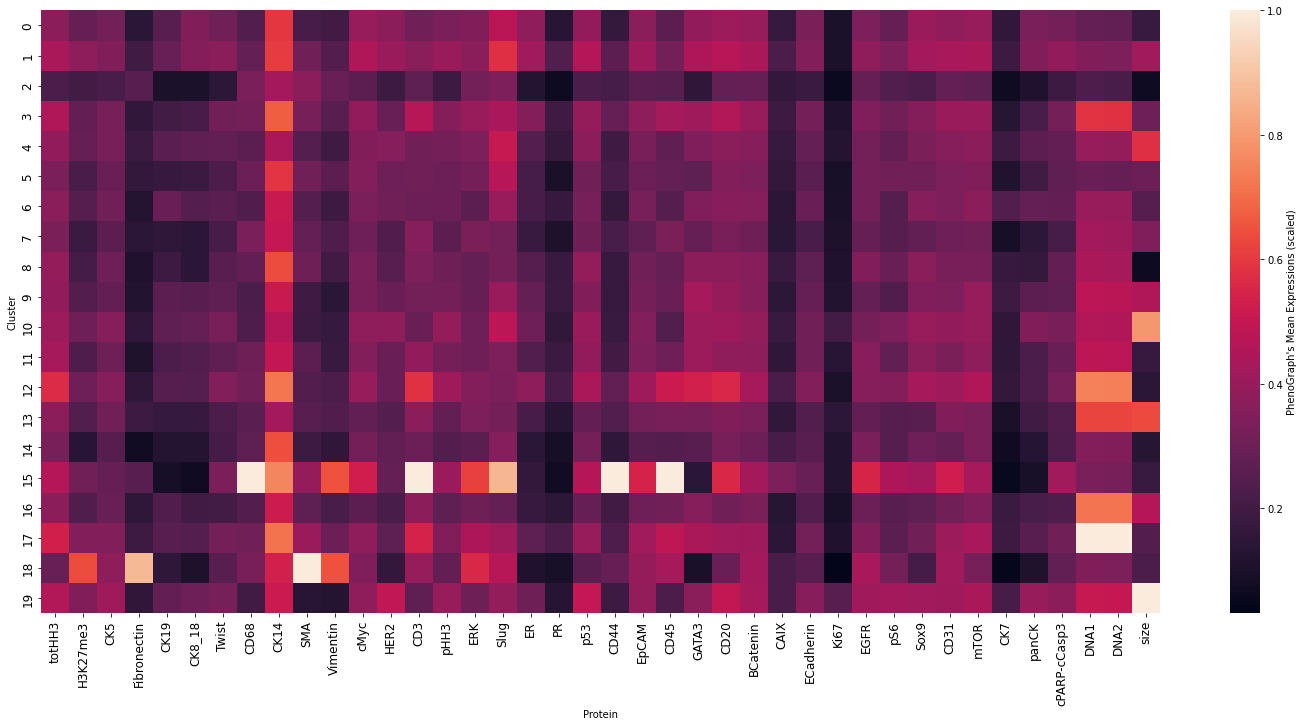

In [31]:
s3 = scaler.transform(pheno_centers)
mat = pd.DataFrame(s3, columns = pretty_printing)
ax = sns.heatmap(mat, yticklabels = True, xticklabels = True, cbar_kws={'label': "PhenoGraph's Mean Expressions (scaled)"})
ax.set_xticklabels(ax.get_xticklabels(), size = 12, horizontalalignment = 'center')
ax.set_yticklabels(ax.get_yticklabels(), size = 12, verticalalignment = 'center')
ax.figure.tight_layout()
plt.xlabel("Protein")
plt.ylabel("Cluster")

### Doublet Prob

In [32]:
rf.predict_proba(pheno_centers)[:,0]

array([0.78, 0.99, 0.44, 0.97, 0.97, 0.99, 0.93, 1.  , 0.48, 0.98, 1.  ,
       0.91, 0.67, 0.99, 0.56, 0.73, 0.99, 0.74, 0.44, 0.99])

## FlowSOM

Text(156.0, 0.5, 'Cluster')

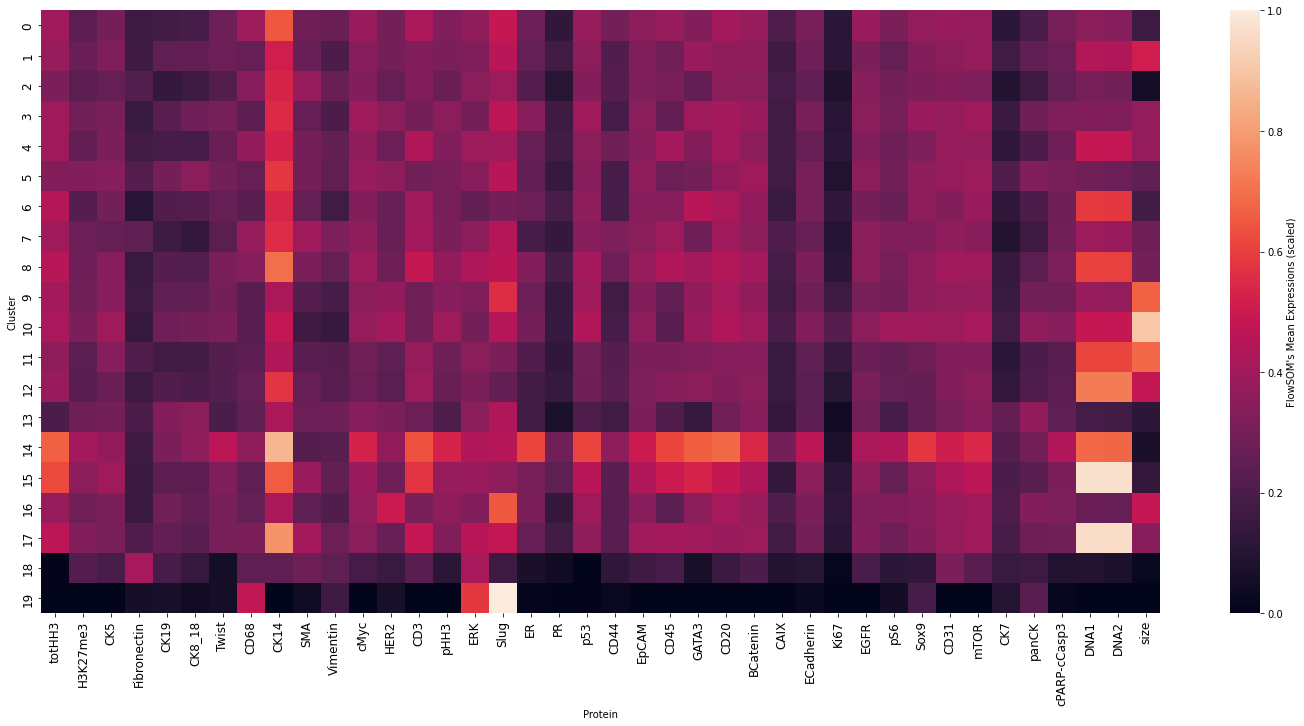

In [33]:
s3 = scaler.transform(fs_centers)
mat = pd.DataFrame(s3, columns = pretty_printing)
ax = sns.heatmap(mat, yticklabels = True, xticklabels = True, cbar_kws={'label': "FlowSOM's Mean Expressions (scaled)"})
ax.set_xticklabels(ax.get_xticklabels(), size = 12, horizontalalignment = 'center')
ax.set_yticklabels(ax.get_yticklabels(), size = 12, verticalalignment = 'center')
ax.figure.tight_layout()
plt.xlabel("Protein")
plt.ylabel("Cluster")

### Doublet Prob

In [34]:
rf.predict_proba(fs_centers)[:,0]

array([0.83, 1.  , 0.51, 0.99, 1.  , 0.9 , 0.89, 0.97, 0.99, 1.  , 1.  ,
       1.  , 0.95, 0.52, 0.36, 0.58, 0.99, 0.78, 0.4 , 0.33])

## Kmeans

Text(156.0, 0.5, 'Cluster')

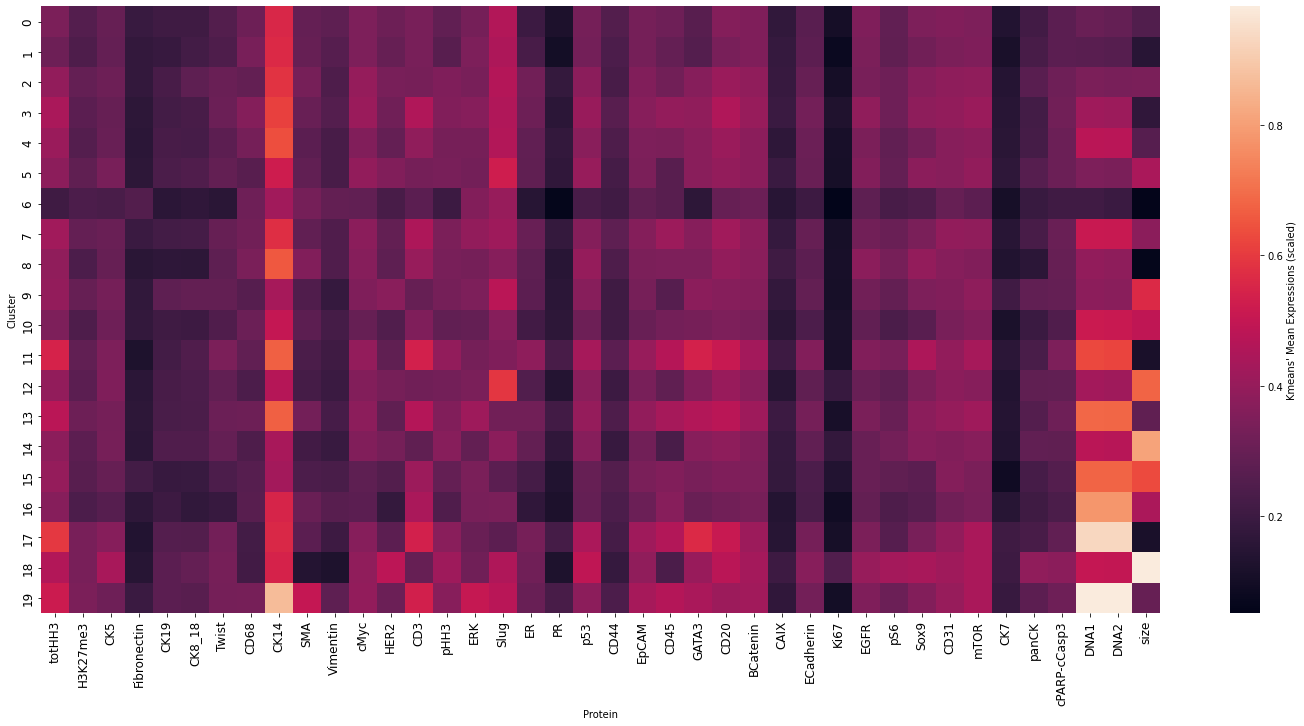

In [35]:
s3 = scaler.transform(okms_centers)
mat = pd.DataFrame(s3, columns = pretty_printing)
ax = sns.heatmap(mat, yticklabels = True, xticklabels = True, cbar_kws={'label': "Kmeans' Mean Expressions (scaled)"})
ax.set_xticklabels(ax.get_xticklabels(), size = 12, horizontalalignment = 'center')
ax.set_yticklabels(ax.get_yticklabels(), size = 12, verticalalignment = 'center')
ax.figure.tight_layout()
plt.xlabel("Protein")
plt.ylabel("Cluster")

### Doublet Prob

In [36]:
rf.predict_proba(okms_centers)[:,0]

array([0.95, 0.77, 0.99, 0.87, 0.96, 1.  , 0.38, 1.  , 0.45, 0.99, 1.  ,
       0.5 , 0.99, 0.97, 1.  , 0.99, 0.92, 0.46, 0.99, 0.78])

# RF on Kmeans

In [37]:
'''
s3 = scaler.transform(okms_centers[singlet_indices])
mat = pd.DataFrame(s3, columns = pretty_printing)
ax = sns.heatmap(mat, yticklabels = True, xticklabels = True, cbar_kws={'label': "RF on Kmeans' Mean Expressions (scaled)"})
ax.set_xticklabels(ax.get_xticklabels(), size = 12, horizontalalignment = 'center')
ax.set_yticklabels(ax.get_yticklabels(), size = 12, verticalalignment = 'center')
ax.figure.tight_layout()
plt.xlabel("Protein")
plt.ylabel("Cluster")
'''

'\ns3 = scaler.transform(okms_centers[singlet_indices])\nmat = pd.DataFrame(s3, columns = pretty_printing)\nax = sns.heatmap(mat, yticklabels = True, xticklabels = True, cbar_kws={\'label\': "RF on Kmeans\' Mean Expressions (scaled)"})\nax.set_xticklabels(ax.get_xticklabels(), size = 12, horizontalalignment = \'center\')\nax.set_yticklabels(ax.get_yticklabels(), size = 12, verticalalignment = \'center\')\nax.figure.tight_layout()\nplt.xlabel("Protein")\nplt.ylabel("Cluster")\n'

In [38]:
#rf.predict_proba(okms_centers[singlet_indices])[:,0]

## DAMM

Text(156.0, 0.5, 'Cluster')

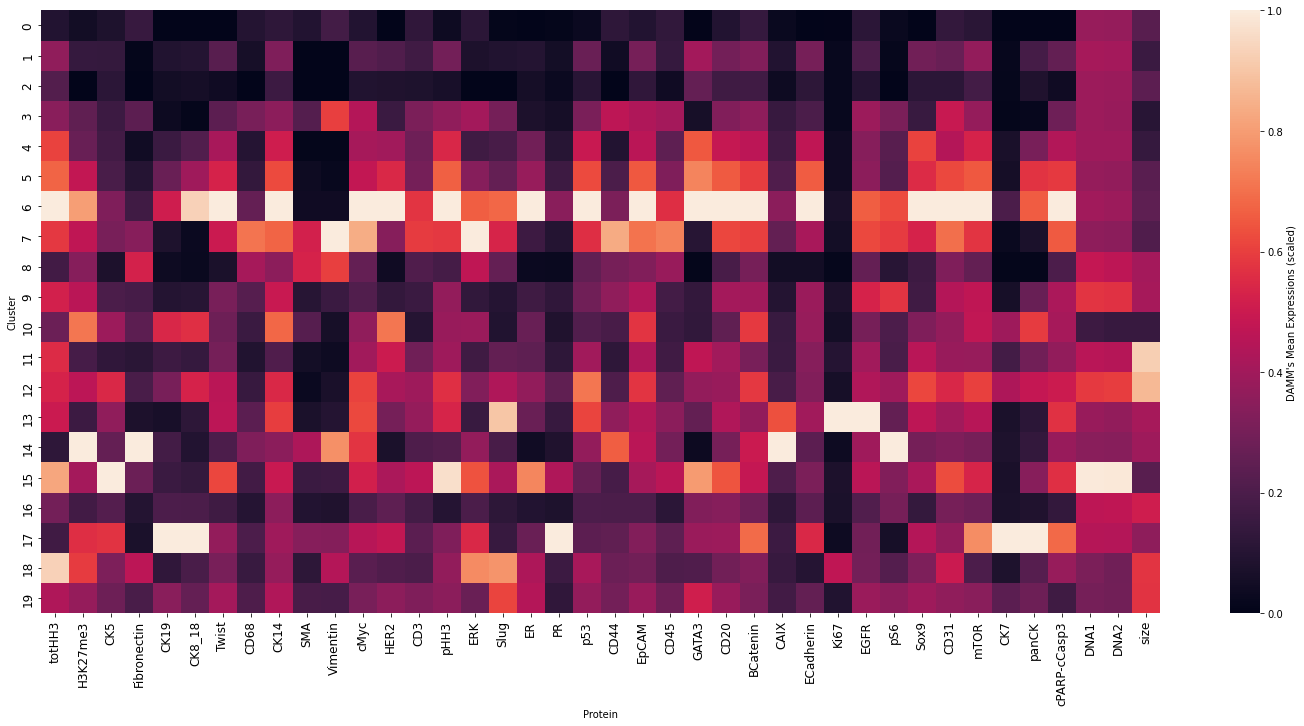

In [39]:
s3 = scaler.transform(damm_centers)
mat = pd.DataFrame(s3, columns = pretty_printing)
ax = sns.heatmap(mat, yticklabels = True, xticklabels = True, cbar_kws={'label': "DAMM's Mean Expressions (scaled)"})
ax.set_xticklabels(ax.get_xticklabels(), size = 12, horizontalalignment = 'center')
ax.set_yticklabels(ax.get_yticklabels(), size = 12, verticalalignment = 'center')
ax.figure.tight_layout()
plt.xlabel("Protein")
plt.ylabel("Cluster")

### Doublet Prob

In [40]:
rf.predict_proba(damm_centers)[:,0]

array([0.27, 0.34, 0.31, 0.19, 0.2 , 0.46, 0.32, 0.45, 0.64, 0.93, 0.36,
       0.99, 0.96, 0.96, 0.51, 0.58, 0.99, 0.88, 0.97, 1.  ])

# UMAP of PhenoGraph/FlowSOM/Kmeans/DAMM clusters

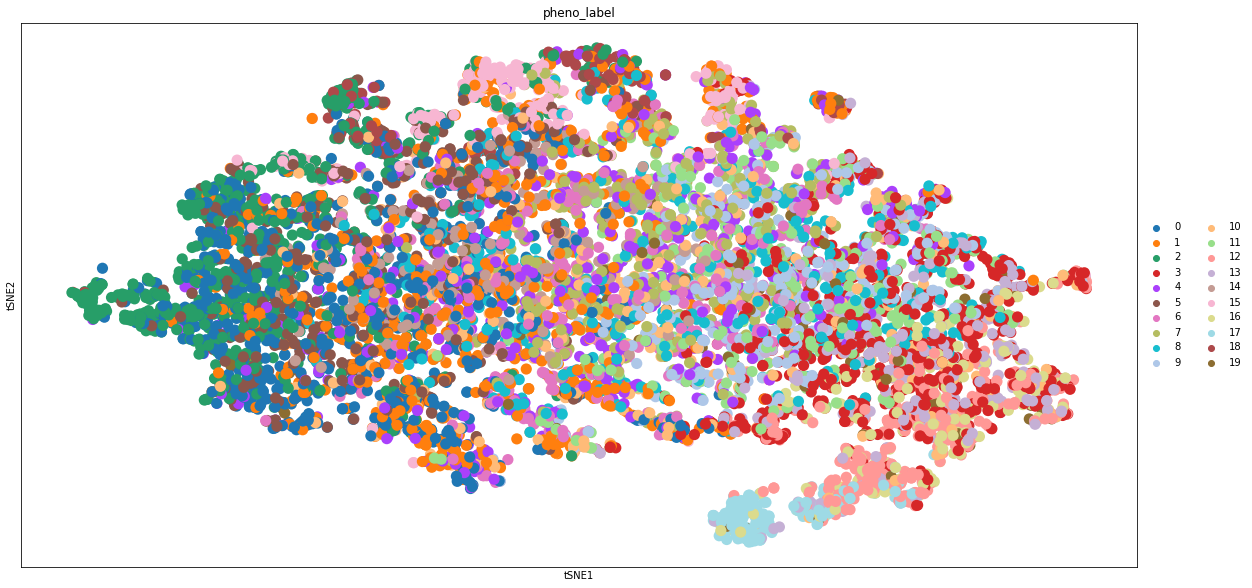

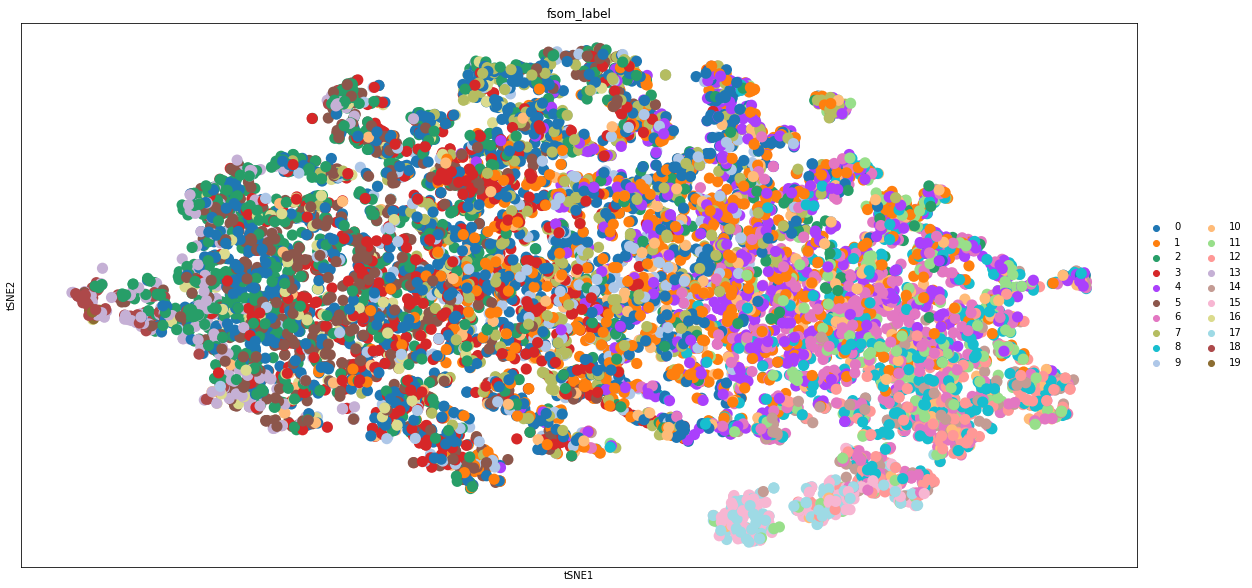

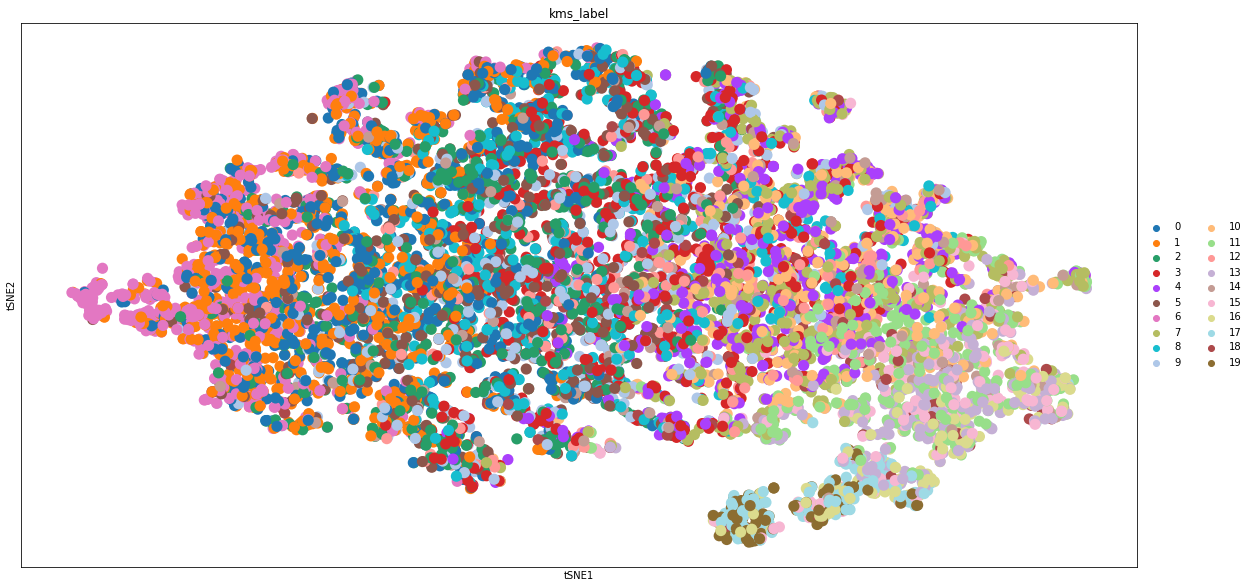

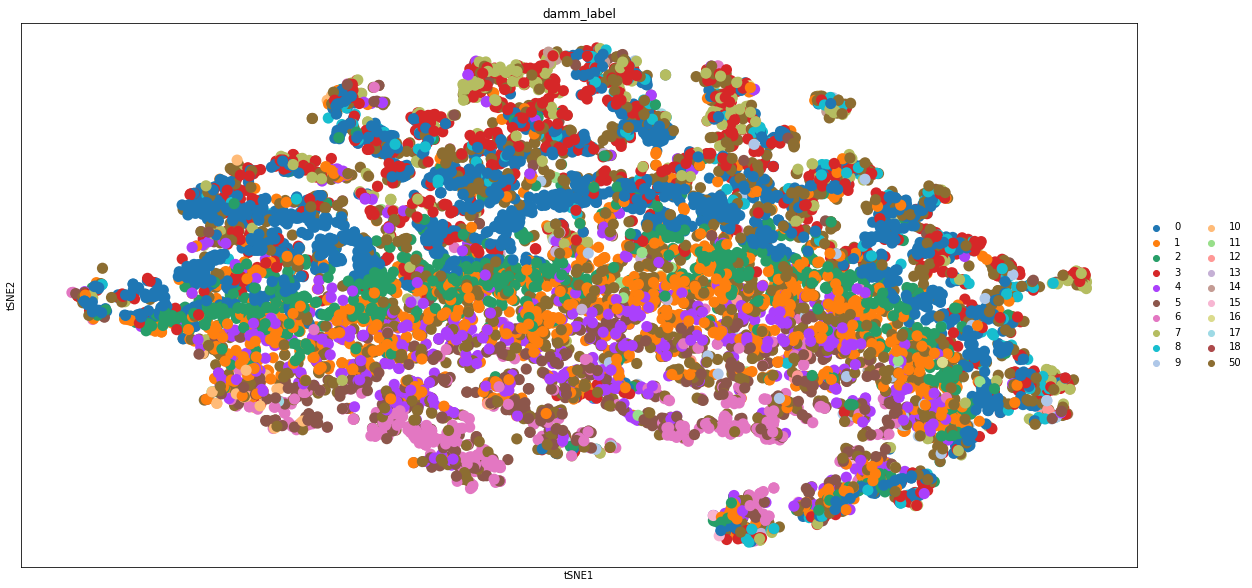

In [41]:
sc.pl.tsne(tr_exp, color="pheno_label", size=500)
sc.pl.tsne(tr_exp, color="fsom_label", size=500)
sc.pl.tsne(tr_exp, color="kms_label", size=500)
sc.pl.tsne(tr_exp, color="damm_label", size=500)

# New Correlation

In [42]:
def newMetric2(mat1, mat2, anti, pairs, thresholds, gp=1):
    out = []
    for pair in pairs:

        x_name = pair[0]; y_name = pair[1]
        #x = np.array(pheno_mat[x_name]); y = np.array(pheno_mat[y_name])
        #x = np.array(damm_mat[x_name]); y = np.array(damm_mat[y_name])
        x1 = np.array(mat1[x_name]); y1 = np.array(mat1[y_name])
        x2 = np.array(mat2[x_name]); y2 = np.array(mat2[y_name])
    
        if anti:
            ## case 1: negative
            score1 = sum((x1 < thresholds[x_name][0]) | (y1 < thresholds[y_name][0]))/len(x1)
            score2 = sum((x2 < thresholds[x_name][0]) | (y2 < thresholds[y_name][0]))/len(x2)
            out.append([x_name + '_' + y_name, score1, score2, 0])
        else:
            ## case 2: positive
            score1 = sum((x1 > thresholds[x_name][1]) | (y1 < thresholds[y_name][0]))/len(x1)
            score2 = sum((x2 > thresholds[x_name][1]) | (y2 < thresholds[y_name][0]))/len(x2)
            out.append([x_name + '_' + y_name, score1, score2, 1])
            
        print("{}_{} -- PG: {}; DAMM: {}".format(x_name, y_name, score1, score2))
        
        '''
        plt.scatter(x1, y1)
        plt.axvline(x=thresholds[x_name][0], color='r')
        plt.axvline(x=thresholds[x_name][1], color='r')    
        plt.axhline(y=thresholds[y_name][0], color='r')
        plt.axhline(y=thresholds[y_name][1], color='r')
        plt.xlabel(x_name)
        plt.ylabel(y_name)
        plt.title("PhenoGraph anti: {}".format(anti))
        plt.show()
        
        plt.scatter(x2, y2)
        plt.axvline(x=thresholds[x_name][0], color='r')
        plt.axvline(x=thresholds[x_name][1], color='r')    
        plt.axhline(y=thresholds[y_name][0], color='r')
        plt.axhline(y=thresholds[y_name][1], color='r')
        plt.xlabel(x_name)
        plt.ylabel(y_name)
        plt.title("DAMM anti: {}".format(anti))
        plt.show()
        '''
    if gp:
        out_col = ['pair', 'PhenoGraph', 'DAMM', 'type']
    else:
        out_col = ['pair', 'FlowSOM', 'DAMM', 'type']
    return pd.DataFrame(out, columns = out_col)

In [43]:
thresholds = pd.DataFrame(np.quantile(tr_exp.X, [0.25, 0.75], axis=0), columns = pretty_printing[:-1])

In [44]:
thresholds

,totHH3,H3K27me3,CK5,Fibronectin,CK19,CK8_18,Twist,CD68,CK14,SMA,...,EGFR,pS6,Sox9,CD31,mTOR,CK7,panCK,cPARP-cCasp3,DNA1,DNA2
0,2.841232,0.558948,0.165770,1.540179,0.162332,0.133127,0.133786,0.075386,0.039210,0.057806,...,0.144066,0.121212,0.032289,0.374640,0.179941,0.082512,0.395066,0.983697,21.907226,39.219485
1,6.642000,1.305141,0.551017,7.368376,0.790052,2.639962,0.400184,0.270004,0.120265,0.582953,...,0.342805,0.502337,0.155318,0.827183,0.418703,0.818566,3.484856,1.988603,35.172943,63.677511


In [48]:
anti_pairs = [['CD3', 'CD20'], 
              ['CD3', 'CD68'], 
              ['CD3', 'panCK'], 
              ['CD3', 'CD31'],
              ['CD20', 'CD68'], 
              ['CD20', 'panCK'], 
              ['CD20', 'CD31'], 
              ['CD45', 'panCK'], 
              ['panCK', 'Vimentin']]
    
co_pairs = [['CD45', 'CD3'],
            ['CD45', 'CD20'],
            ['CD45', 'CD68'],
            ['panCK', 'CK5'],
            ['panCK', 'CK7'],
            ['panCK', 'CK8_18'],
            ['panCK', 'CK19']]

In [46]:
#!pip install --upgrade matplotlib>=3.3.4

In [49]:
pheno_mat = pd.DataFrame(pheno_centers, columns = pretty_printing)
damm_mat = pd.DataFrame(damm_centers, columns = pretty_printing)
anti = newMetric2(pheno_mat, damm_mat, 1, anti_pairs, thresholds, 1)
co = newMetric2(pheno_mat, damm_mat, 0, co_pairs, thresholds, 1)
df = pd.concat([anti, co])

CD3_CD20 -- PG: 0.0; DAMM: 0.1
CD3_CD68 -- PG: 0.0; DAMM: 0.05
CD3_panCK -- PG: 0.0; DAMM: 0.15
CD3_CD31 -- PG: 0.0; DAMM: 0.1
CD20_CD68 -- PG: 0.0; DAMM: 0.1
CD20_panCK -- PG: 0.0; DAMM: 0.1
CD20_CD31 -- PG: 0.0; DAMM: 0.1
CD45_panCK -- PG: 0.0; DAMM: 0.15
panCK_Vimentin -- PG: 0.0; DAMM: 0.2
CD45_CD3 -- PG: 0.25; DAMM: 0.25
CD45_CD20 -- PG: 0.25; DAMM: 0.25
CD45_CD68 -- PG: 0.25; DAMM: 0.25
panCK_CK5 -- PG: 0.2; DAMM: 0.4
panCK_CK7 -- PG: 0.2; DAMM: 0.45
panCK_CK8_18 -- PG: 0.2; DAMM: 0.45
panCK_CK19 -- PG: 0.2; DAMM: 0.45


Text(0.5, 0.98, 'meta: Correlation Alternative')

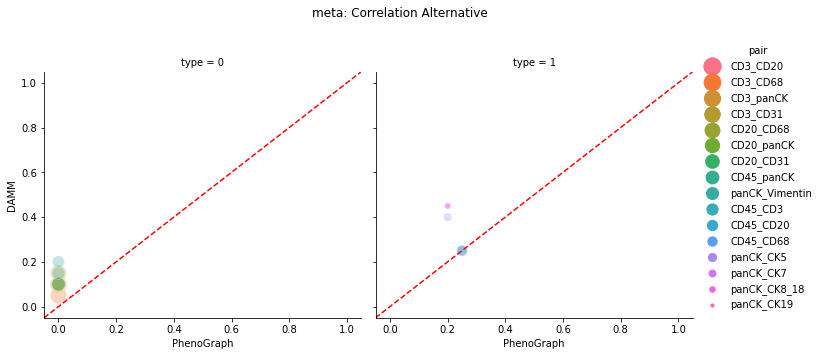

In [50]:
rel = sns.relplot(data=df, x='PhenoGraph', y='DAMM', col='type', hue='pair', size="pair", sizes=(10, 300), alpha = 0.3)
#rel = sns.relplot(data=df, x='PhenoGraph', y='DAMM', col='type', hue='pair')
for ax in rel.axes_dict.values():
    ax.axline((0, 0), (1,1), ls="--", color ='red')
#rel.data = df  # Hack needed to work around bug on v0.11, fixed in v0.12.dev
#rel.map(sns.lineplot, 'PhenoGraph', 'DAMM')
rel.fig.subplots_adjust(top=.8)
rel.fig.suptitle('{}: Correlation Alternative'.format(cohort))

In [51]:
fs_mat = pd.DataFrame(fs_centers, columns = pretty_printing)
anti = newMetric2(fs_mat, damm_mat, 1, anti_pairs, thresholds, 0)
co = newMetric2(fs_mat, damm_mat, 0, co_pairs, thresholds, 0)
df = pd.concat([anti, co])

CD3_CD20 -- PG: 0.05; DAMM: 0.1
CD3_CD68 -- PG: 0.05; DAMM: 0.05
CD3_panCK -- PG: 0.05; DAMM: 0.15
CD3_CD31 -- PG: 0.05; DAMM: 0.1
CD20_CD68 -- PG: 0.05; DAMM: 0.1
CD20_panCK -- PG: 0.05; DAMM: 0.1
CD20_CD31 -- PG: 0.05; DAMM: 0.1
CD45_panCK -- PG: 0.05; DAMM: 0.15
panCK_Vimentin -- PG: 0.0; DAMM: 0.2
CD45_CD3 -- PG: 0.3; DAMM: 0.25
CD45_CD20 -- PG: 0.3; DAMM: 0.25
CD45_CD68 -- PG: 0.25; DAMM: 0.25
panCK_CK5 -- PG: 0.35; DAMM: 0.4
panCK_CK7 -- PG: 0.3; DAMM: 0.45
panCK_CK8_18 -- PG: 0.3; DAMM: 0.45
panCK_CK19 -- PG: 0.3; DAMM: 0.45


Text(0.5, 0.98, 'meta: Correlation Alternative')

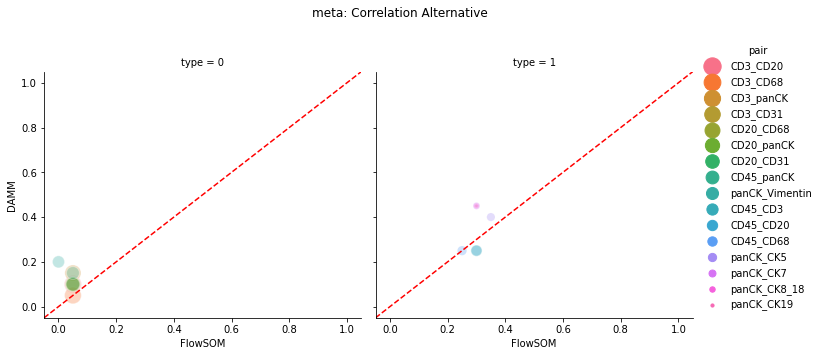

In [52]:
rel = sns.relplot(data=df, x='FlowSOM', y='DAMM', col='type', hue='pair', size="pair", sizes=(10, 300), alpha = 0.3)
#rel = sns.relplot(data=df, x='PhenoGraph', y='DAMM', col='type', hue='pair')
for ax in rel.axes_dict.values():
    ax.axline((0, 0), (1,1), ls="--", color ='red')
#rel.data = df  # Hack needed to work around bug on v0.11, fixed in v0.12.dev
#rel.map(sns.lineplot, 'PhenoGraph', 'DAMM')
rel.fig.subplots_adjust(top=.8)
rel.fig.suptitle('{}: Correlation Alternative'.format(cohort))

# ARS of PhenoGraph/FlowSOM/Kmeans/DAMM

In [53]:
from sklearn.metrics.cluster import adjusted_rand_score
adjusted_rand_score(tr_exp.obs['pheno_label'], tr_exp.obs['fsom_label'])

0.32785560277939724

In [54]:
adjusted_rand_score(tr_exp.obs['pheno_label'], tr_exp.obs['kms_label'])

0.3925749198717487

In [55]:
adjusted_rand_score(tr_exp.obs['pheno_label'], tr_exp.obs['damm_label'])

0.020293427092332682

In [56]:
adjusted_rand_score(tr_exp.obs['fsom_label'], tr_exp.obs['kms_label'])

0.42599776509206905

In [57]:
adjusted_rand_score(tr_exp.obs['fsom_label'], tr_exp.obs['damm_label'])

0.01749667937470232

In [58]:
adjusted_rand_score(tr_exp.obs['kms_label'], tr_exp.obs['damm_label'])

0.013574669840335006

# Confusion matrix of PG/FS vs DAMM clusters

In [59]:
##remove doublet cells
singlet_set = tr_exp.obs[tr_exp.obs['damm_label'] != '50']

In [60]:
singlet_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8256 entries, MB0249_1_532_136 to MB0473_1_316_758
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   sample        8256 non-null   category
 1   id            8256 non-null   int64   
 2   x             8256 non-null   float64 
 3   y             8256 non-null   float64 
 4   area          8256 non-null   int64   
 5   area_convex   8256 non-null   int64   
 6   pheno_label   8256 non-null   category
 7   fsom_label    8256 non-null   category
 8   kms_label     8256 non-null   category
 9   damm_label    8256 non-null   category
 10  prob_doublet  8256 non-null   float64 
dtypes: category(5), float64(3), int64(3)
memory usage: 523.1+ KB


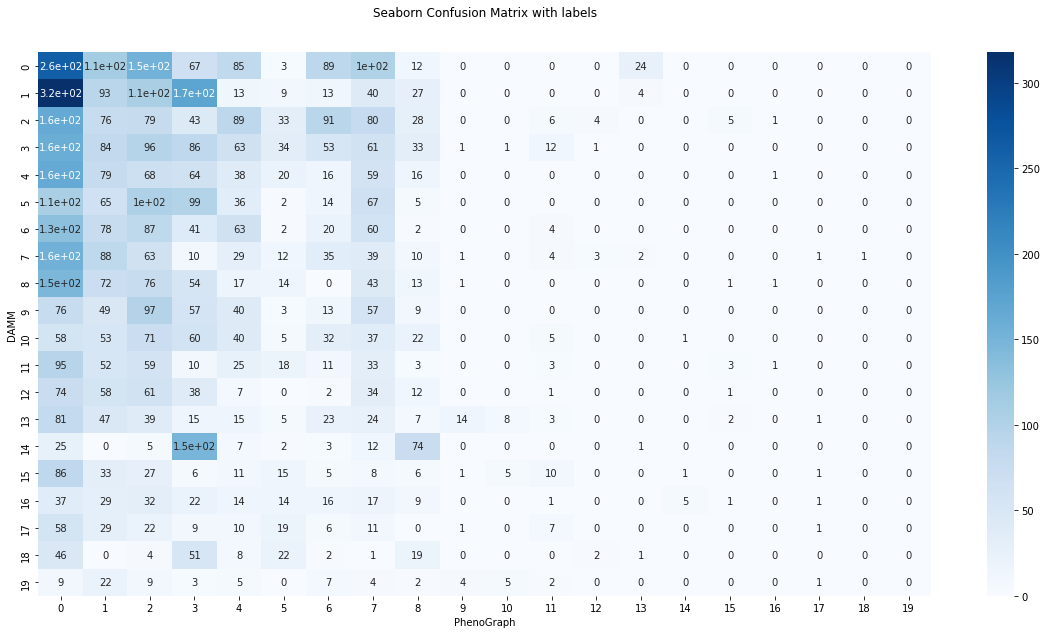

In [61]:
##use singlet cells to compute confusion matrix
cf_mat = confusion_matrix(singlet_set['pheno_label'], singlet_set['damm_label'], labels = singlet_set['pheno_label'].value_counts().index)

ax = sns.heatmap(cf_mat, annot=True, cmap='Blues');

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('PhenoGraph');
ax.set_ylabel('DAMM');

## Ticket labels - List must be in alphabetical order
#ax.xaxis.set_ticklabels(['False','True'])
#ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

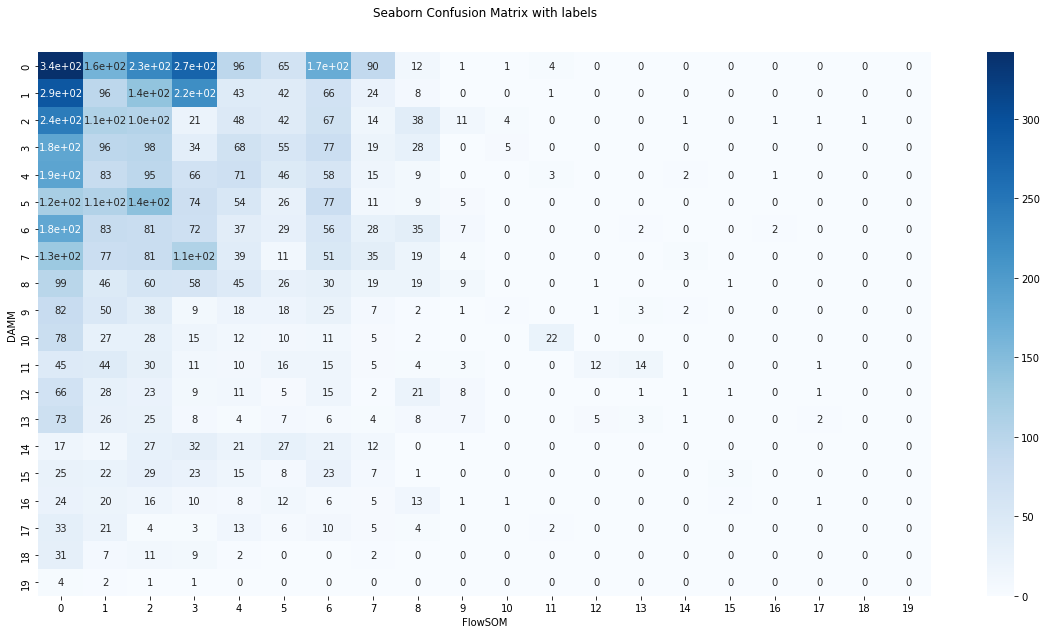

In [62]:
cf_mat = confusion_matrix(singlet_set['fsom_label'], singlet_set['damm_label'], labels = singlet_set['fsom_label'].value_counts().index)

ax = sns.heatmap(cf_mat, annot=True, cmap='Blues');

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('FlowSOM');
ax.set_ylabel('DAMM');

## Ticket labels - List must be in alphabetical order
#ax.xaxis.set_ticklabels(['False','True'])
#ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

# Doublet distribution

In [63]:
doublet_set = tr_exp.obs[tr_exp.obs['damm_label'] == '50']

In [64]:
doublet_set['pheno_label'].value_counts()

4     270
1     227
10    168
13    156
9     146
5     115
3     111
7     103
0      90
6      56
19     52
2      51
16     51
11     30
18     26
17     23
12     21
15     20
8      18
14     10
Name: pheno_label, dtype: int64

In [65]:
doublet_set['fsom_label'].value_counts()

1     365
4     174
9     166
3     149
10    139
11    133
5     111
0      99
7      84
16     61
12     59
8      55
2      52
6      42
17     20
13     15
15     11
18      6
14      3
19      0
Name: fsom_label, dtype: int64

# Pinch Effect

In [ ]:
#area of convex hull of cell / area of cell

In [66]:
np.mean(singlet_set['area_convex']/singlet_set['area'])

1.128439667568768

In [67]:
np.mean(doublet_set['area_convex']/doublet_set['area'])

1.1255269440781592

# Cell sizes by cluster

<AxesSubplot:xlabel='cluster', ylabel='size'>

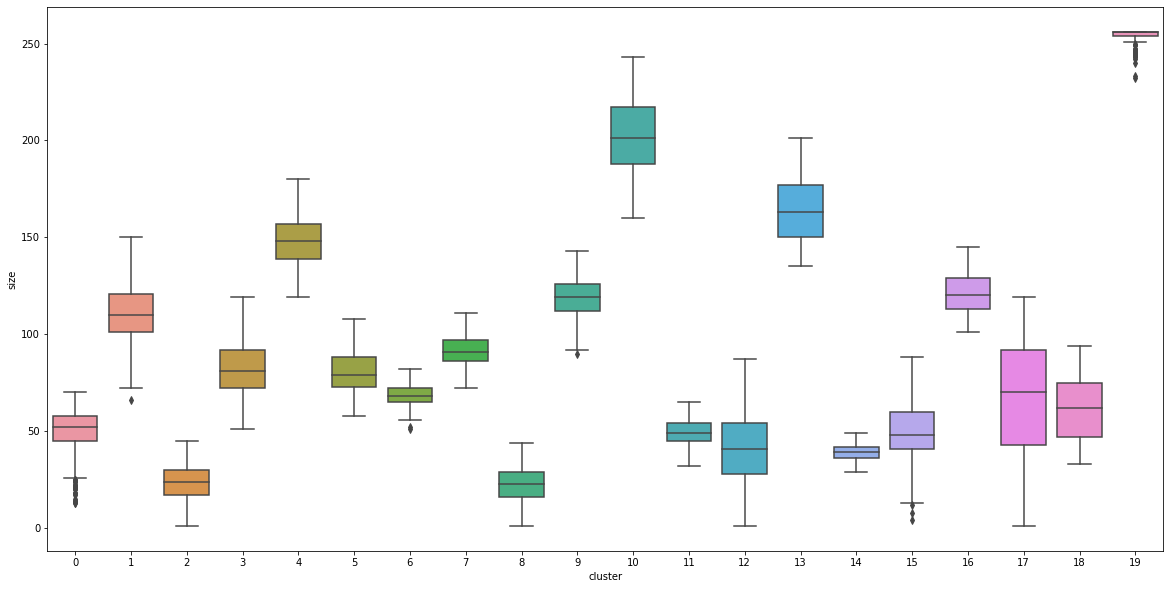

In [68]:
## phenograph
d1 = pd.DataFrame({'cluster': range(pheno_centers.shape[0]), 'psi': pheno_centers[:,-1]})
d2 = pd.DataFrame({'size': trS, 'cluster': pheno_labels})
d3 = d2.merge(d1, on='cluster')
sns.boxplot(x = 'cluster', y = 'size', data = d3)

<AxesSubplot:xlabel='cluster', ylabel='size'>

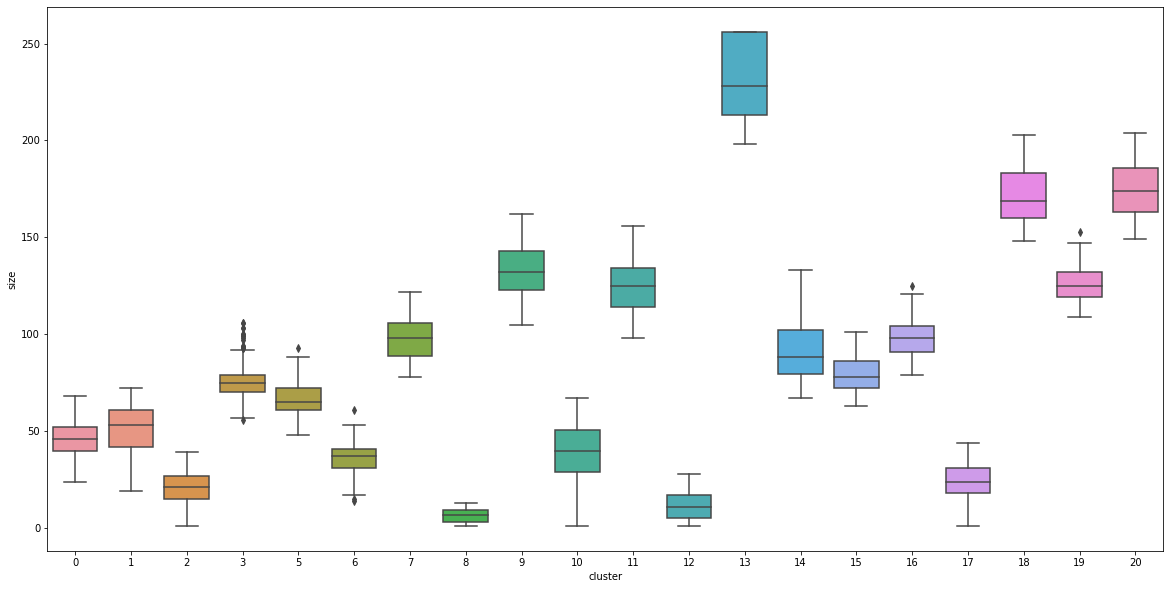

In [69]:
## FlowSOM
d1 = pd.DataFrame({'cluster': fsom_sorted_by_count, 'psi': fs_centers[:,-1]})
d2 = pd.DataFrame({'size': trS, 'cluster': fsom_labels})
d3 = d2.merge(d1, on='cluster')
sns.boxplot(x = 'cluster', y = 'size', data = d3)

<AxesSubplot:xlabel='cluster', ylabel='size'>

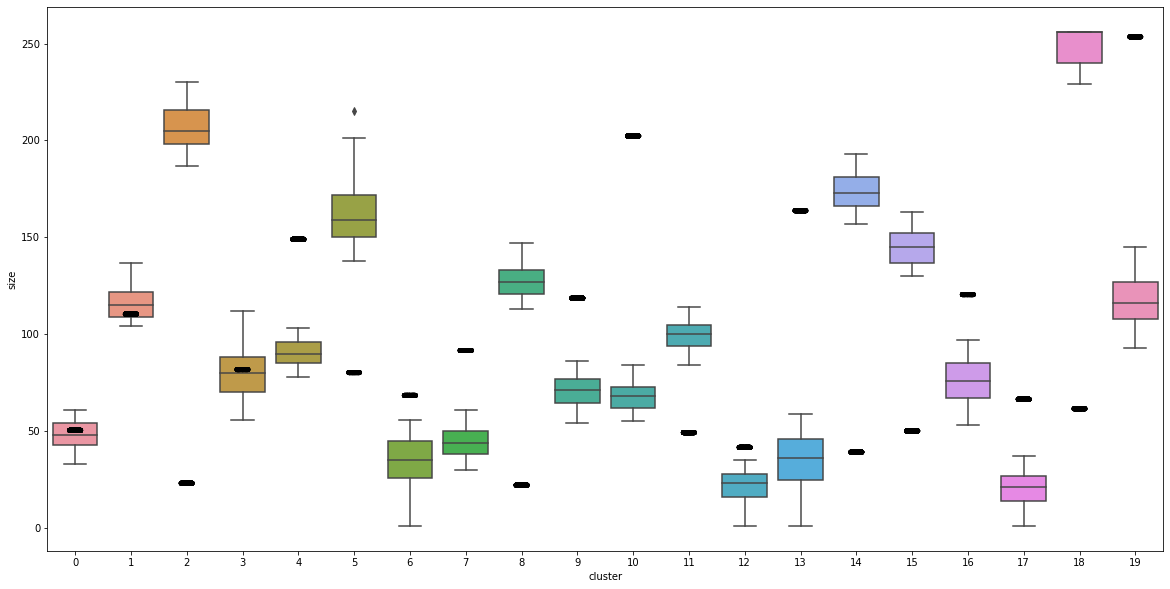

In [70]:
## kmeans
d1 = pd.DataFrame({'cluster': range(pheno_centers.shape[0]), 'psi': pheno_centers[:,-1]})
d2 = pd.DataFrame({'size': trS, 'cluster': okms_labels})
d3 = d2.merge(d1, on='cluster')

sns.stripplot(x = 'cluster', y = 'psi', data = d3, color = 'black')
sns.boxplot(x = 'cluster', y = 'size', data = d3)

<AxesSubplot:xlabel='cluster', ylabel='size'>

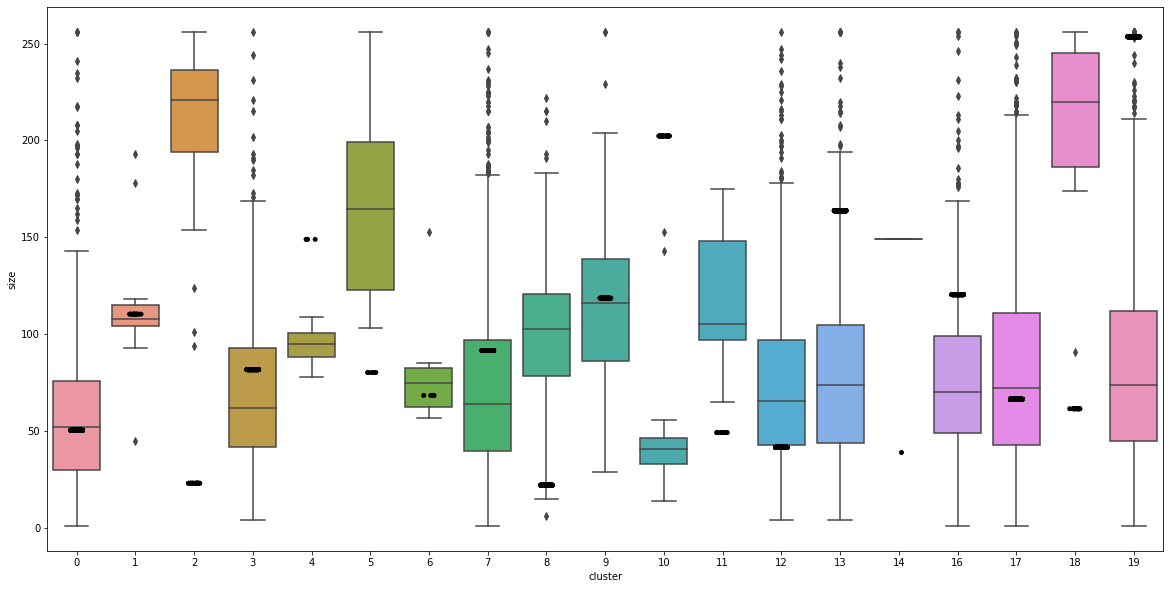

In [71]:
## damm
d1 = pd.DataFrame({'cluster': range(pheno_centers.shape[0]), 'psi': pheno_centers[:,-1]})
d2 = pd.DataFrame({'size': np.array(trS[damm_pred_singlet_label == 0]), 
                   'cluster': damm_pred_singlet_cluster_assig_label})
d3 = d2.merge(d1, on='cluster')

sns.stripplot(x = 'cluster', y = 'psi', data = d3, color = 'black')
sns.boxplot(x = 'cluster', y = 'size', data = d3)

In [ ]:
'''
analysisProteins = ['B220', 'CCR7', 'CD11b', 'CD11c', 'CD19', 'CD28', 'CD3', 'CD31', 'CD4',
       'CD45', 'CD49b', 'CD68', 'CD73', 'CD8', 'CTLA4', 'DNA1', 'DNA3',
       'Epithelium', 'FOXP3', 'GATA3', 'GFP', 'GranzymeB', 'HA', 'ICOS',
       'IL7Ra', 'Ly6G', 'MHCII', 'PD1', 'PDL1', 'PNAd', 'Perforin', 'RFP',
       'S100A8-9', 'Stroma', 'TBET', 'TCF1', 'YAP', 'iNOS']

    pretty_printing = ['B220', 'CCR7', 'CD11b', 'CD11c', 'CD19', 'CD28', 'CD3', 'CD31', 'CD4',
        'CD45', 'CD49b', 'CD68', 'CD73', 'CD8', 'CTLA4', 'DNA1', 'DNA3',
        'Epithelium', 'FOXP3', 'GATA3', 'GFP', 'GranzymeB', 'HA', 'ICOS',
        'IL7Ra', 'Ly6G', 'MHCII', 'PD1', 'PDL1', 'PNAd', 'Perforin', 'RFP',
        'S100A8-9', 'Stroma', 'TBET', 'TCF1', 'YAP', 'iNOS', 'size']

    analysisProteins = ['totHH3', 'H3K27me3', 'CK5', 'Fibronectin', 'CK19',
                'CK8_18', 'Twist', 'CD68', 'CK14', 'SMA', 'Vimentin', 'cMyc', 'HER2', 'CD3', 'pHH3', 'ERK',
                'Slug', 'ER', 'PR', 'p53', 'CD44', 'EpCAM', 'CD45', 'GATA3', 'CD20', 'bCatenin', 'CAIX',
                'ECadherin', 'Ki67', 'EGFR', 'pS6', 'Sox9', 'CD31', 'mTOR', 'CK7', 'panCK', 'cPARP-cCasp3',
                'DNA1', 'DNA2']

    pretty_printing = ['totHH3', 'H3K27me3', 'CK5', 'Fibronectin', 'CK19',
                'CK8_18', 'Twist', 'CD68', 'CK14', 'SMA', 'Vimentin', 'cMyc', 'HER2', 'CD3', 'pHH3', 'ERK',
                'Slug', 'ER', 'PR', 'p53', 'CD44', 'EpCAM', 'CD45', 'GATA3', 'CD20', 'bCatenin', 'CAIX',
                'ECadherin', 'Ki67', 'EGFR', 'pS6', 'Sox9', 'CD31', 'mTOR', 'CK7', 'panCK', 'cPARP-cCasp3',
                'DNA1', 'DNA2', 'size']
    
    analysisProteins = ['TotalHH3', 'H3K27me3', 'Cytokeratin5', 'Fibronectin',
       'Cytokeratin19', 'Cytokeratin8/18', 'Twist', 'CD68', 'Keratin14', 'SMA',
       'Vimentin', 'cMyc', 'cerbB2_Her2', 'CD3', 'phospho_HH3', 'Erk1/2',
       'Slug', 'RabbitIgGHL', 'Progesterone_Receptor_A/B', 'p53', 'CD44',
       'EpCAM', 'CD45', 'GATA3', 'CD20', 'bCatenin', 'Carbonic_Anhydrase_IX',
       'Ecadherin', 'Ki67', 'EGFR', 'S6', 'Sox9', 'vWF_CD31', 'mTOR',
       'Cytokeratin7', 'panCytokeratin/Keratin_Epithelial',
       'cleavedPARP_CleavedCaspase3', 'DNA1', 'DNA2']

    pretty_printing = ['totHH3', 'H3K27me3', 'CK5', 'Fibronectin', 'CK19', 'CK8_18', 'Twist', 'CD68', 'KK14', 'SMA', 'Vimentin', 'cMyc', 
         'Her2', 'CD3', 'pHH3', 'ERK', 'Slug', 'RabbitIgGHL', 'PR', 'p53', 'CD44', 'EpCAM', 'CD45', 'GATA3',
         'CD20', 'bCatenin', 'CAIX', 'ECadherin', 'Ki67', 'EGFR', 'S6', 'Sox9', 'CD31', 'mTOR', 'CK7', 'panCK',
         'cPARP-cCasp3', 'DNA1', 'DNA2', 'size']
'''